In [2]:
%matplotlib inline
import os
import sys
import numpy
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
#from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score

def progress(i, end_val, bar_length=50):
    '''
    Print a progress bar of the form: Percent: [#####      ]
    i is the current progress value expected in a range [0..end_val]
    bar_length is the width of the progress bar on the screen.
    '''
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()

NEWLINE = '\n'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [5]:
# Needed for Lingustic Analysis
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# We will visualize the messages with a word cloud
from wordcloud import WordCloud


# Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

# Import Tf-idf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Import the Label Encoder
from sklearn.preprocessing import LabelEncoder

# Import the train test split
from sklearn.model_selection import train_test_split

# To evaluate our model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('/content/gdrive/MyDrive/data2/lokay-m',      HAM),
    ('/content/gdrive/MyDrive/data2/BG',    SPAM),
    
]

SKIP_FILES = {'cmds'}


def read_files(path):
    '''
    Generator of pairs (filename, filecontent)
    for all files below path whose name is not in SKIP_FILES.
    The content of the file is of the form:
        header....
        <emptyline>
        body...
    This skips the headers and returns body only.
    '''
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    f = open(file_path, encoding="latin-1")
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content


def build_data_frame(l, path, classification):
    rows = []
    index = []
    for i, (file_name, text) in enumerate(read_files(path)):
        if ((i+l) % 100 == 0):
            progress(i+l, 58910, 50)
        rows.append({'text': text, 'class': classification})
        index.append(file_name)
   
    data_frame = DataFrame(rows, index=index)
    return data_frame, len(rows)

def load_data():
    data = DataFrame({'text': [], 'class': []})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification)
        data = data.append(data_frame)
        l += nrows
    data = data.reindex(numpy.random.permutation(data.index))
    return data

In [8]:
# This should take about 2 minutes
data=load_data()

Percent: [##########                                        ] 21%

In [9]:
len(data)

12368

In [10]:
data.describe()

,text,class
count,12368,12368
unique,11016,2
top,,spam
freq,11,10003


In [11]:
#data.dropna(subset = ["Message"], inplace=True)
# Display firt five rows
display(data.head())

# Display the summary statistics
display(data.describe())

# Print the info
print(data.info())

,text,class
/content/gdrive/MyDrive/data2/lokay-m/articles/34,September Forecast\n\n---------------------- F...,ham
/content/gdrive/MyDrive/data2/BG/2005/01/1105516126.17811_111.txt,--0-9540846829-8317196431=:76411\n\nContent-Ty...,spam
/content/gdrive/MyDrive/data2/BG/2005/04/1113068315.17005_125.txt,"Dear Sir,\n\n\n\nYou will be surprise to see t...",spam
/content/gdrive/MyDrive/data2/BG/2005/01/1105030213.11343_7.txt,Good day:\n\n\n\nMr. Costello just called from...,spam
/content/gdrive/MyDrive/data2/BG/2005/05/1116478460.21530_53.txt,<html>\n\n<b>pre-ejeculators:</b><br>\n\npleas...,spam


,text,class
count,12368,12368
unique,11016,2
top,,spam
freq,11,10003


<class 'pandas.core.frame.DataFrame'>
Index: 12368 entries, /content/gdrive/MyDrive/data2/lokay-m/articles/34 to /content/gdrive/MyDrive/data2/BG/2005/05/1117404505.8026_11.txt
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12368 non-null  object
 1   class   12368 non-null  object
dtypes: object(2)
memory usage: 289.9+ KB
None


In [12]:
data.dropna(subset = ["text"], inplace=True)
# Display firt five rows
display(data.head())


,text,class
/content/gdrive/MyDrive/data2/lokay-m/articles/34,September Forecast\n\n---------------------- F...,ham
/content/gdrive/MyDrive/data2/BG/2005/01/1105516126.17811_111.txt,--0-9540846829-8317196431=:76411\n\nContent-Ty...,spam
/content/gdrive/MyDrive/data2/BG/2005/04/1113068315.17005_125.txt,"Dear Sir,\n\n\n\nYou will be surprise to see t...",spam
/content/gdrive/MyDrive/data2/BG/2005/01/1105030213.11343_7.txt,Good day:\n\n\n\nMr. Costello just called from...,spam
/content/gdrive/MyDrive/data2/BG/2005/05/1116478460.21530_53.txt,<html>\n\n<b>pre-ejeculators:</b><br>\n\npleas...,spam


spam    0.808781
ham     0.191219
Name: class, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


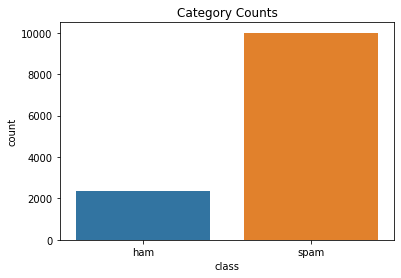

In [13]:
# Print the counts of each category
#print(data['Spam/Ham'].value_counts())

# Print the proportions of each category
print(data['class'].value_counts(normalize=True))

# Visualize the Categories
sns.countplot(data['class'])
plt.title("Category Counts")
plt.show()

In [13]:
# Initialize the Label Encoder.
le = LabelEncoder()

# Encode the categories
data['Category_enc'] = le.fit_transform(data['class'])

# Display the first five rows again to see the result
display(data.head())

# Print the datatypes
print(data.dtypes)

,text,class,Category_enc
/content/gdrive/MyDrive/data2/BG/2004/09/1094422612.7695_290.txt,----00815343105475\n\nContent-Type: text/plain...,spam,1
/content/gdrive/MyDrive/data2/BG/2005/01/1106058990.3277_438.txt,MR.WANG QIN.\n\nDAH SING BANK LTD.\n\n19 DES V...,spam,1
/content/gdrive/MyDrive/data2/BG/2004/11/1101760455.12757_466.txt,FROM MRS DORIS DILLY\n\nABIDJAN COTE D'IVOIRE\...,spam,1
/content/gdrive/MyDrive/data2/BG/2004/11/1100467965.14355_257.txt,----7082169785.52696875882765.727\n\nContent-T...,spam,1
/content/gdrive/MyDrive/data2/BG/2005/07/1122504290.14258_1357.txt,How funny is this !?^M^M\n\n^M^M\n\n^M^M\n\nI ...,spam,1


text            object
class           object
Category_enc     int64
dtype: object


class
ham     236.115856
spam    308.641608
Name: word_count, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


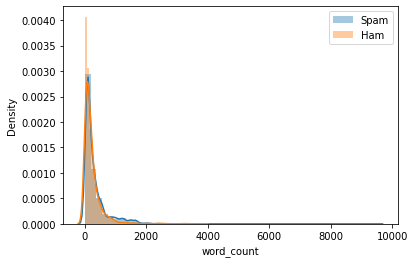

In [14]:
# Store the number of words in each messages
data['word_count'] = data['text'].str.split().str.len()

# Print the average number of words in each category
print(data.groupby('class')['word_count'].mean())

# Visualize the distribution of word counts in each category
sns.distplot(data[data['class']=='spam']['word_count'], label='Spam')
sns.distplot(data[data['class']=='ham']['word_count'], label='Ham'),
plt.legend()
plt.show()

In [15]:
# Make the letters lower case and tokenize the words
tokenized_messages = data['text'].str.lower().apply(word_tokenize)

# Print the tokens to see how it looks like
print(tokenized_messages)

/content/gdrive/MyDrive/data2/BG/2004/09/1094422612.7695_290.txt      [--, --, 00815343105475, content-type, :, text...
/content/gdrive/MyDrive/data2/BG/2005/01/1106058990.3277_438.txt      [mr.wang, qin, ., dah, sing, bank, ltd., 19, d...
/content/gdrive/MyDrive/data2/BG/2004/11/1101760455.12757_466.txt     [from, mrs, doris, dilly, abidjan, cote, d'ivo...
/content/gdrive/MyDrive/data2/BG/2004/11/1100467965.14355_257.txt     [--, --, 7082169785.52696875882765.727, conten...
/content/gdrive/MyDrive/data2/BG/2005/07/1122504290.14258_1357.txt    [how, funny, is, this, !, ?, ^m^m, ^m^m, ^m^m,...
                                                                                            ...                        
/content/gdrive/MyDrive/data2/BG/2004/12/1103924356.5155_3.txt        [--, --, 60272059437812977403, content-type, :...
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/761         [jeff, /, michelle, ,, here, is, the, daily, u...
/content/gdrive/MyDrive/data2/BG/2004/09

In [17]:
# Define a function to returns only alphanumeric tokens
def alpha(tokens):
    """This function removes all non-alphanumeric characters"""
    alpha = []
    for token in tokens:
        if str.isalpha(token) or token in ['n\'t','won\'t']:
            if token=='n\'t':
                alpha.append('not')
                continue
            elif token == 'won\'t':
                alpha.append('wont')
                continue
            alpha.append(token)
    return alpha

# Apply our function to tokens
tokenized_messages = tokenized_messages.apply(alpha)

print(tokenized_messages)

/content/gdrive/MyDrive/data2/BG/2004/09/1094422612.7695_290.txt      [changed, eyes, embarrass, position, convenien...
/content/gdrive/MyDrive/data2/BG/2005/01/1106058990.3277_438.txt      [qin, dah, sing, bank, des, voeux, rd, central...
/content/gdrive/MyDrive/data2/BG/2004/11/1101760455.12757_466.txt     [mrs, doris, dilly, abidjan, cote, greetings, ...
/content/gdrive/MyDrive/data2/BG/2004/11/1100467965.14355_257.txt     [east, marriage, pleasure, finding, million, e...
/content/gdrive/MyDrive/data2/BG/2005/07/1122504290.14258_1357.txt    [funny, get, online, get, email, gina, invites...
                                                                                            ...                        
/content/gdrive/MyDrive/data2/BG/2004/12/1103924356.5155_3.txt        [boule, cycad, antacid, always, wanted, date, ...
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/761                  [jeff, michelle, daily, update, suzanne]
/content/gdrive/MyDrive/data2/BG/2004/09

In [16]:
# Define a function to remove stop words
def remove_stop_words(tokens):
    """This function removes all stop words in terms of nltk stopwords"""
    no_stop = []
    for token in tokens:
        if token not in stopwords.words('english'):
            no_stop.append(token)
    return no_stop

# Apply our function to tokens
tokenized_messages = tokenized_messages.apply(remove_stop_words)

print(tokenized_messages)

/content/gdrive/MyDrive/data2/BG/2004/09/1094422612.7695_290.txt      [--, --, 00815343105475, content-type, :, text...
/content/gdrive/MyDrive/data2/BG/2005/01/1106058990.3277_438.txt      [mr.wang, qin, ., dah, sing, bank, ltd., 19, d...
/content/gdrive/MyDrive/data2/BG/2004/11/1101760455.12757_466.txt     [mrs, doris, dilly, abidjan, cote, d'ivoire, 0...
/content/gdrive/MyDrive/data2/BG/2004/11/1100467965.14355_257.txt     [--, --, 7082169785.52696875882765.727, conten...
/content/gdrive/MyDrive/data2/BG/2005/07/1122504290.14258_1357.txt    [funny, !, ?, ^m^m, ^m^m, ^m^m, get, online, g...
                                                                                            ...                        
/content/gdrive/MyDrive/data2/BG/2004/12/1103924356.5155_3.txt        [--, --, 60272059437812977403, content-type, :...
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/761         [jeff, /, michelle, ,, daily, update, 10th, .,...
/content/gdrive/MyDrive/data2/BG/2004/09

In [18]:
# Define a function to lemmatization
def lemmatize(tokens):
    """This function lemmatize the messages"""
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    # Create the lemmatized list
    lemmatized = []
    for token in tokens:
            # Lemmatize and append
            lemmatized.append(lemmatizer.lemmatize(token))
    return " ".join(lemmatized)

# Apply our function to tokens
tokenized_messages = tokenized_messages.apply(lemmatize)

print(tokenized_messages)

/content/gdrive/MyDrive/data2/BG/2004/09/1094422612.7695_290.txt      changed eye embarrass position convenient past...
/content/gdrive/MyDrive/data2/BG/2005/01/1106058990.3277_438.txt      qin dah sing bank de voeux rd central hong kon...
/content/gdrive/MyDrive/data2/BG/2004/11/1101760455.12757_466.txt     mr doris dilly abidjan cote greeting write ins...
/content/gdrive/MyDrive/data2/BG/2004/11/1100467965.14355_257.txt     east marriage pleasure finding million earth t...
/content/gdrive/MyDrive/data2/BG/2005/07/1122504290.14258_1357.txt    funny get online get email gina invite join fa...
                                                                                            ...                        
/content/gdrive/MyDrive/data2/BG/2004/12/1103924356.5155_3.txt        boule cycad antacid always wanted date lonely ...
/content/gdrive/MyDrive/data2/lokay-m/tw_commercial_group/761                        jeff michelle daily update suzanne
/content/gdrive/MyDrive/data2/BG/2004/09

In [19]:
# Replace the columns with tokenized messages
data['text'] = tokenized_messages

# Display the first five rows
display(data.head(10))

,text,class,Category_enc,word_count
/content/gdrive/MyDrive/data2/BG/2004/09/1094422612.7695_290.txt,changed eye embarrass position convenient past...,spam,1,521
/content/gdrive/MyDrive/data2/BG/2005/01/1106058990.3277_438.txt,qin dah sing bank de voeux rd central hong kon...,spam,1,551
/content/gdrive/MyDrive/data2/BG/2004/11/1101760455.12757_466.txt,mr doris dilly abidjan cote greeting write ins...,spam,1,318
/content/gdrive/MyDrive/data2/BG/2004/11/1100467965.14355_257.txt,east marriage pleasure finding million earth t...,spam,1,173
/content/gdrive/MyDrive/data2/BG/2005/07/1122504290.14258_1357.txt,funny get online get email gina invite join fa...,spam,1,118
/content/gdrive/MyDrive/data2/BG/2005/03/1110215830.19216_177.txt,eighth acquisitive antiquary ejaculate within ...,spam,1,175
/content/gdrive/MyDrive/data2/BG/2005/01/1105608554.14698_119.txt,wheeler continue important expected u c p larg...,spam,1,907
/content/gdrive/MyDrive/data2/BG/2004/11/1101760455.12757_522.txt,plain text message area recipient email progra...,spam,1,259
/content/gdrive/MyDrive/data2/BG/2004/10/1098391538.17033_105.txt,html real gold rolex replica look exactly like...,spam,1,67
/content/gdrive/MyDrive/data2/BG/2004/09/1095104891.24230_11.txt,discount generic drug save today special viagr...,spam,1,43


In [20]:
# Select the features and the target
X = data['text']
y = data['Category_enc']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)

In [22]:
# Create the tf-idf vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii')
#x = vectorizer.fit_transform(df['Message'].values.astype('U'))
# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform(X_train)

# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)

In [23]:
from sklearn.linear_model import LogisticRegression

logclassifier=LogisticRegression()
logclassifier.fit(tfidf_train, y_train)
print("Accuracy:",logclassifier.score(tfidf_test, y_test))

Accuracy: 0.986661277283751


In [24]:
predictions = logclassifier.predict(tfidf_test)
cr = classification_report(predictions, y_test)
print(cr)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       440
           1       1.00      0.98      0.99      2034

    accuracy                           0.99      2474
   macro avg       0.97      0.99      0.98      2474
weighted avg       0.99      0.99      0.99      2474

